# Recurrent Neural Networks (with training batches)

**Reference:** http://karpathy.github.io/2015/05/21/rnn-effectiveness/

## Notes:
- **RNNs are more flexible**
  - Vanilla Neural Networks (and even Convolutional Networks) are limited.
    - They can only accept a fixed-sized vector as input.
    - They can only produce a fixed-sized vector as output.
    - This mapping is done with a fixed number of computational steps.
  - On the other hand, Recurrent Neural Networks (in their most general form) are able to accept **variable length inputs**, produce **variable length outputs**, and even **vary the number of computational steps** for different lengths.
- **Classification of RNNs**
  - RNNs can be classified into **5 types** depending on the input and output lengths (see the image in the reference blogpost for a visual explanation):
    - **One-to-one:** this is just a Vanilla Neural Network.
    - **One-to-many:** e.g. image captining (fixed size image to variable size caption).
    - **Many-to-one:** e.g sentiment analysis (variable sized text to binary sentiment).
    - **Many-to-many (asynced):** e.g machine translation (variable sized input sequence and output sequence).
    - **Many-to-many (synced):** e.g video classification (variable sized input sequence, output sequence is same size as input sequence).
  - Note that a sequence refers to a sequence of vectors. The sequence has variable length but the size of each vector in the sequence is fixed.
- **Optimizing over functions**
  - The ability for RNNs to **vary the number of computational steps (while maintaining the same number of learnable parameters)** is where the magic happens.
  - **RNNs are Turing-Complete** (but similar to universal approximation theorems for neural nets you shouldn’t read too much into this. In fact, forget I said anything.)
  - If training vanilla neural nets is optimization over functions, training recurrent nets is optimization over programs.
- **Sequential processing in absence of sequences**
  - You might be thinking that having sequences as inputs or outputs could be relatively rare.
  - However, even if your inputs/outputs are fixed vectors, it is still possible to use this powerful formalism to **process them in a sequential manner**.
  - You’re learning stateful programs that process your fixed-sized data.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
torch.set_printoptions(linewidth=140)

In [2]:
words = open("names.txt", "r").read().splitlines()
print(f"First few words: {words[:5]}\nNumber of words: {len(words)}")

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Number of words: 32033


In [3]:
chars = ["<S>", "<E>"] + sorted(set("".join(words)))
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}
vocab_size = len(chars)

In [4]:
longest_word_length = max([len(word) for word in words])
print(f"Length of longest word: {longest_word_length}")

Length of longest word: 15


In [5]:
def build_dataset(words, longest_word_length, verbose=False):
  X, Y = [], []
  for word in words:
    word_as_list = ["<S>"] + list(word) + ["<E>"]
    word_vector = [char_to_ix[char] for char in word_as_list]
    x = word_vector[:-1] + [char_to_ix["<E>"]]*(longest_word_length-len(word))
    y = word_vector[1:] + [char_to_ix["<E>"]]*(longest_word_length-len(word))
    X.append(x)
    Y.append(y)
  X, Y = torch.tensor(X), torch.tensor(Y)
  if verbose:
    print(f"{X.shape}\t{Y.shape}")
  return X, Y

In [6]:
random.seed(5)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1], longest_word_length, verbose=True)
X_dev, Y_dev = build_dataset(words[n1:n2], longest_word_length, verbose=True)
X_test, Y_test = build_dataset(words[n2:], longest_word_length, verbose=True)

torch.Size([25626, 16])	torch.Size([25626, 16])
torch.Size([3203, 16])	torch.Size([3203, 16])
torch.Size([3204, 16])	torch.Size([3204, 16])


In [7]:
for x, y in zip(X_train[:10], Y_train[:10]):
  print(f"{x.tolist()}\t->\t{y.tolist()}")

[0, 13, 6, 25, 10, 15, 8, 21, 16, 15, 1, 1, 1, 1, 1, 1]	->	[13, 6, 25, 10, 15, 8, 21, 16, 15, 1, 1, 1, 1, 1, 1, 1]
[0, 21, 10, 21, 22, 20, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	->	[21, 10, 21, 22, 20, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 6, 14, 14, 6, 21, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1]	->	[6, 14, 14, 6, 21, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2, 13, 6, 10, 8, 9, 2, 1, 1, 1, 1, 1, 1, 1, 1]	->	[2, 13, 6, 10, 8, 9, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 5, 2, 14, 2, 19, 10, 6, 1, 1, 1, 1, 1, 1, 1, 1]	->	[5, 2, 14, 2, 19, 10, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 15, 16, 2, 4, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	->	[15, 16, 2, 4, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 3, 19, 10, 25, 21, 6, 15, 1, 1, 1, 1, 1, 1, 1, 1]	->	[3, 19, 10, 25, 21, 6, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 14, 2, 19, 13, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	->	[14, 2, 19, 13, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2, 15, 15, 2, 3, 6, 21, 9, 1, 1, 1, 1, 1, 1, 1]	->	[2, 15, 15, 2, 3, 6, 21, 9, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 14, 2, 19, 12, 26

In [8]:
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weights = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weights[IX]
    return self.out
  
  def parameters(self):
    return [self.weights]


class RNNCell:
  
  def __init__(self, input_size, output_size, hidden_size):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_layer_size = hidden_size
    self.W_ax = torch.randn((input_size, hidden_size)) / input_size**0.5
    self.W_aa = torch.randn((hidden_size, hidden_size)) / hidden_size**0.5
    self.b_a = torch.zeros(1, hidden_size)
    self.W_ay = torch.randn((hidden_size, output_size)) / hidden_size**0.5
    self.b_y = torch.zeros(1, output_size)
  
  def __call__(self, x, a): # x is a batch of vectors of size input_size
    self.out_a = torch.tanh(x @ self.W_ax + a @ self.W_aa + self.b_a)
    self.out_y = torch.tanh(self.out_a @ self.W_ay + self.b_y).tanh()
    return self.out_y, self.out_a
  
  def parameters(self):
    return [self.W_ax, self.W_aa, self.b_a, self.W_ay, self.b_y]


class RNN:
  
  def __init__(self, input_size, output_size, hidden_size):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.rnn_cell = RNNCell(input_size, output_size, hidden_size)
  
  def __call__(self, X, a=None): # x is a batch of sequences of vectors, a is a batch of hidden state vectors
    if a==None:
      a = torch.zeros(X.shape[0], self.hidden_size)
    out = []
    for x in X.unbind(dim=1):
      y, a = self.rnn_cell(x, a)
      out.append(y)
    self.out = torch.stack(out, dim=1)
    return self.out
  
  def parameters(self):
    return self.rnn_cell.parameters()


class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
    
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(5);

In [10]:
embedding_size = 8
hidden_size = 256

model = Sequential([
  Embedding(vocab_size, embedding_size),
  RNN(embedding_size, vocab_size, hidden_size),
])

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

75260


In [11]:
# example forward pass with a batch of size 4
Xb = X_train[torch.randint(0, X_train.shape[0], (4,))] # batch of size 4
print(f"Input: {tuple(Xb.shape)}")
logits = model(Xb)
for layer in model.layers:
  print(f"{layer.__class__.__name__}: {tuple(layer.out.shape)}")

Input: (4, 16)
Embedding: (4, 16, 8)
RNN: (4, 16, 28)


In [12]:
max_steps = 10_000
batch_size = 64
lossi = []

for step in range(max_steps):
  
  # minibatch construct
  ixs = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb, Yb = X_train[ixs], Y_train[ixs]
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits.reshape(-1, vocab_size), Yb.reshape(-1))
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if step < 7_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad # type: ignore
  
  # track stats
  if step % 100 == 0:
    print(f"{step}/{max_steps}\t{loss.item():.4f}")
  lossi.append(loss.item())

0/10000	3.6659
100/10000	2.3610
200/10000	2.3558
300/10000	2.3248
400/10000	2.3309
500/10000	2.3120
600/10000	2.3009
700/10000	2.3127
800/10000	2.3140
900/10000	2.2953
1000/10000	2.3015
1100/10000	2.3002
1200/10000	2.3053
1300/10000	2.2905
1400/10000	2.3175
1500/10000	2.3050
1600/10000	2.2562
1700/10000	2.2942
1800/10000	2.2849
1900/10000	2.2881
2000/10000	2.3118
2100/10000	2.2777
2200/10000	2.3087
2300/10000	2.2824
2400/10000	2.2861
2500/10000	2.3225
2600/10000	2.3086
2700/10000	2.2604
2800/10000	2.3014
2900/10000	2.2893
3000/10000	2.2719
3100/10000	2.2688
3200/10000	2.2929
3300/10000	2.2747
3400/10000	2.2792
3500/10000	2.2543
3600/10000	2.2467
3700/10000	2.3067
3800/10000	2.2792
3900/10000	2.2980
4000/10000	2.2775
4100/10000	2.2655
4200/10000	2.2696
4300/10000	2.2592
4400/10000	2.2646
4500/10000	2.2752
4600/10000	2.2831
4700/10000	2.2942
4800/10000	2.2684
4900/10000	2.2614
5000/10000	2.2421
5100/10000	2.2421
5200/10000	2.2649
5300/10000	2.2599
5400/10000	2.2735
5500/10000	2.2935
5600

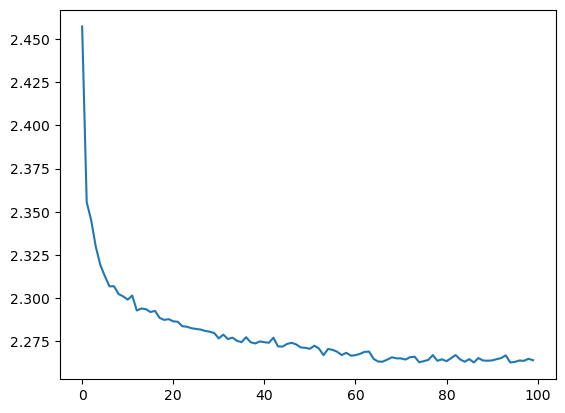

In [13]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(dim=1));

In [14]:
@torch.no_grad() # disables gradient tracking
def evaluate(X, Y):
    logits = model(X)
    loss = F.cross_entropy(logits.reshape(-1, vocab_size), Y.reshape(-1))
    return loss.item()

In [15]:
print(f"Training split loss: {evaluate(X_train, Y_train):.4f}")
print(f"Development split loss: {evaluate(X_dev, Y_dev):.4f}")

Training split loss: 2.2636
Development split loss: 2.2648


Why is the loss so high?

In [16]:
print(f"Test split loss: {evaluate(X_test, Y_test):.4f}")

Test split loss: 2.2689


In [18]:
with torch.no_grad():
  g = torch.Generator().manual_seed(5)

  C = model.layers[0].weights
  rnn_cell = model.layers[1].rnn_cell
  
  for char in chars[2:]:
    
    print(char, end="")
    # char = "<S>"
    a = torch.zeros(1, hidden_size)
    out = []
    
    while True:
      
      ix = char_to_ix[char]
      emb = C[ix]
    
      logits, a = rnn_cell(emb, a)
      probs = F.softmax(logits, dim=1)
    
      ix = int(torch.argmax(probs).item()) 
      # multinomial(probs, num_samples=1, generator=g).item()) # why does this not work?
      if ix==char_to_ix["<E>"]:
        break
      char = ix_to_char[ix]
      out.append(char)
      
    print("".join(out))

aniella
bannel
ckanie
dylani
ellani
fann
gevianay
hianna
ikani
jhunvvromiellan
kaniel
lania
mevian
n
oriann
phzkenvvmrvjmlvidyllena
qikandellan
remiella
shiania
tandellan
u
vianna
wynn
xlian
ylania
zelania
